First you should download the geographic map from [this site](https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2/ETOPO2v2-2006/ETOPO2v2c/netCDF/ETOPO2v2c_f4_netCDF.zip).

TODO List:
- [ ] Implement functionality to visualize PV values by time of day, enabling detailed moment-to-moment change.
- [ ] Substitute current coarse geographic maps with higher-resolution alternatives for enhanced accuracy.
- [ ] Generate graphs illustrating trends in PV values over time, facilitating insightful analysis.
- [ ] Enhance the user interface by refining the layout and optimizing the presentation of legends.
- [ ] Integrate into `quartz_solar_forecast` as a submodule.

In [5]:
from quartz_solar_forecast.forecast import run_forecast
from quartz_solar_forecast.pydantic_models import PVSite
import xarray as xr
ds = xr.open_dataset('ETOPO2v2c_f4.nc')
ds

<xarray.Dataset>
Dimensions:  (x: 10800, y: 5400)
Coordinates:
  * x        (x) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9 180.0
  * y        (y) float32 -89.98 -89.95 -89.92 -89.88 ... 89.88 89.92 89.95 89.98
Data variables:
    z        (y, x) float32 ...
Attributes:
    Conventions:  COARDS
    title:        
    source:                               -Rd -I2m -ZTLf                     ...
    node_offset:  1

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm.notebook import tqdm

In [126]:
lon = np.linspace(min(ds['x'].data),max(ds['x'].data),len(ds['x'].data))
lat = np.linspace(min(ds['y'].data),max(ds['y'].data),len(ds['y'].data))

lon_begin = -7.6 # -180 ~ 180
lon_end = 1.6 # -180 ~ 180
lat_begin = 50.8 # -90 ~ 90
lat_end = 58.5 # -90 ~ 90

lon_begin_index = np.argmax(lon>lon_begin)
lon_end_index = np.argmax(lon>lon_end)
lat_begin_index = np.argmax(lat>lat_begin)
lat_end_index = np.argmax(lat>lat_end)

lon_new = lon[lon_begin_index:lon_end_index]
lat_new = lat[lat_begin_index:lat_end_index]

lon, lat = np.meshgrid(lon_new, lat_new)
dem = ds['z'].data[lat_begin_index:lat_end_index,lon_begin_index:lon_end_index]
print(lon.size,lat.size,dem.size)

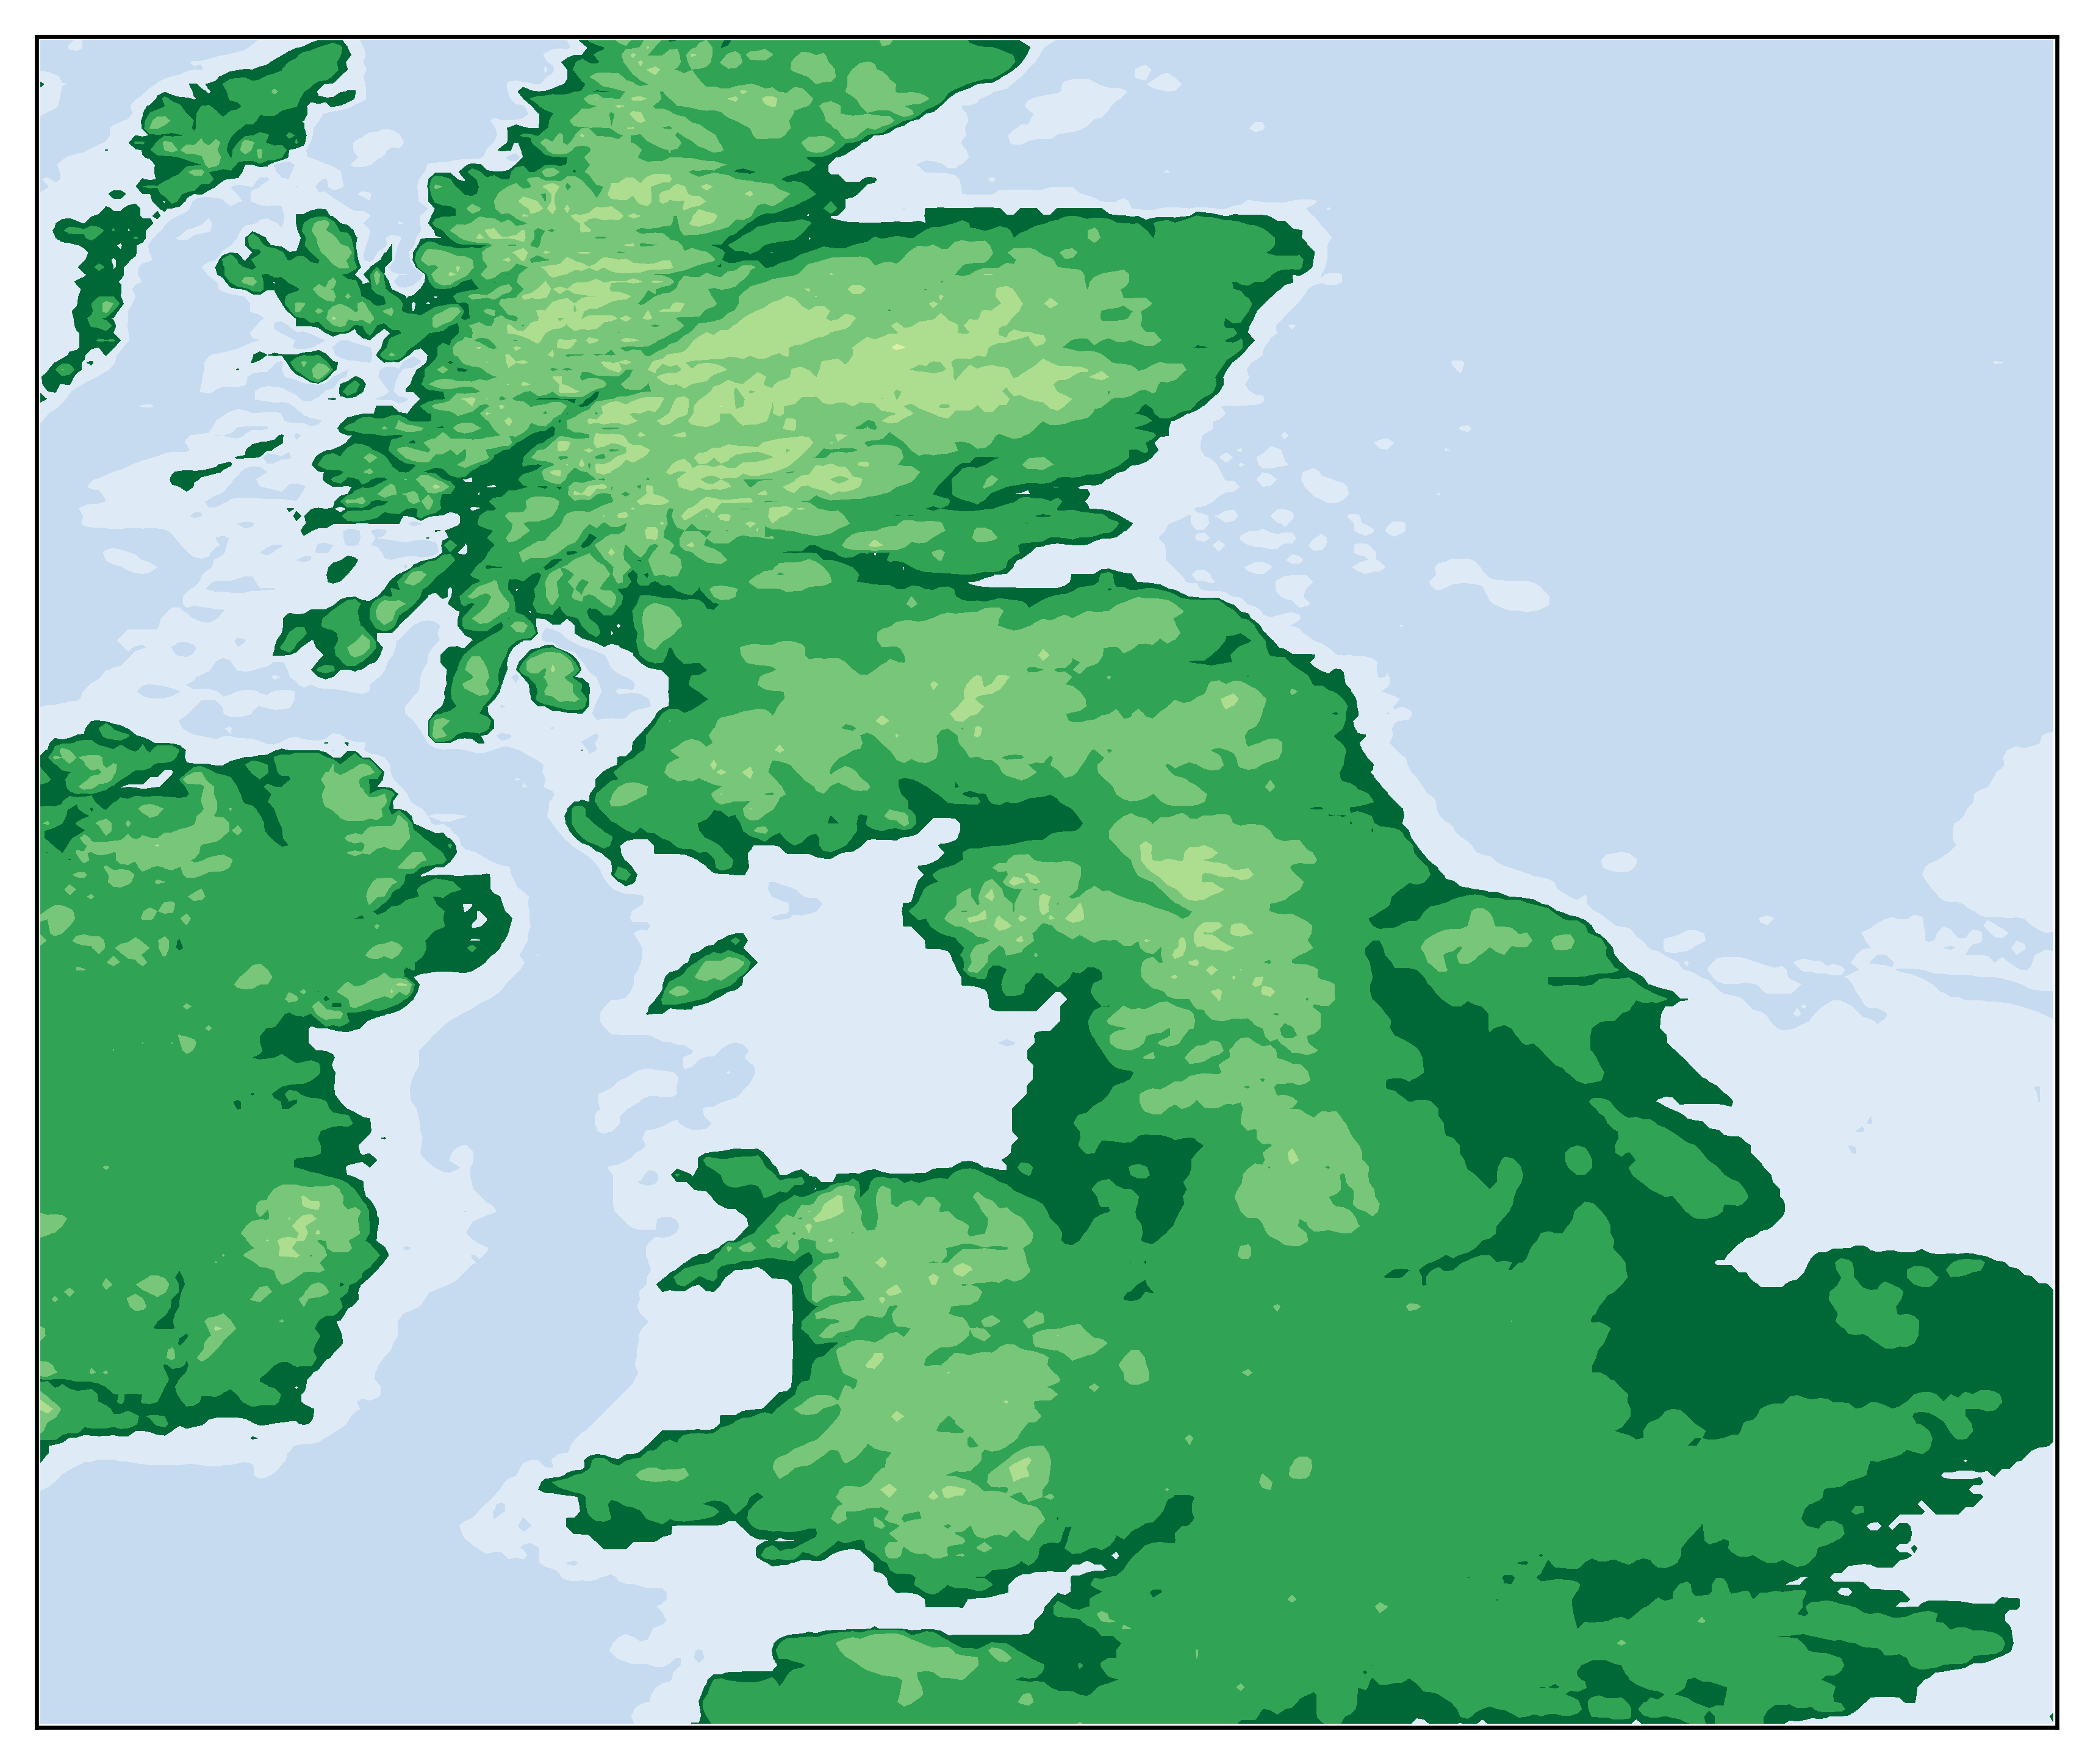

In [131]:
# Draw geographic map
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # Set font as Times New Roman
plt.figure(figsize=(10, 6), dpi=600)
# fig, m = plt.subplots()
# m = Basemap(projection='cyl',resolution='h',llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90)
m = Basemap(projection='cyl',resolution='h',llcrnrlon=lon_begin,llcrnrlat=lat_begin,urcrnrlon=lon_end,urcrnrlat=lat_end)
levels = [-8000,-6000, -4000, -2000, -1000, -200, -50, 0, 50, 200, 500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
# levels = 
color = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#006837', 
             '#31a354', '#78c679', '#addd8e', '#d9f0a3', '#f7fcb9', '#c9bc87', '#a69165', '#856b49', 
             '#664830', '#ad9591', '#d7ccca']
m.contourf(lon, lat, dem, levels=levels[5:-5], extend='both', colors=color[5:-5]) 
# m.imshow()
# heat_data = np.sin(np.sqrt(lon**2 + lat**2))
# m.imshow(heat_data,cmap='rainbow',alpha=0.4)

# set the tick bar
# cb = m.colorbar(location='bottom', pad=0.35)  
# cb.set_ticks(levels[5:-5]) 
# cb.ax.tick_params(labelsize=10)  # set tick font size
# cb.set_label('Global Elevation (meter)', fontsize=12)  

plt.savefig('brit_elevation.jpg', dpi=600, bbox_inches='tight', pad_inches=0.1)  

plt.show()  # 显示地图

In [136]:
x_step = 20
y_step = 20

In [137]:
pv_array = np.zeros([x_step,y_step])
for i,x in enumerate(tqdm(np.linspace(lat_begin,lat_end,x_step))):
    for j,y in enumerate(np.linspace(lon_begin,lon_end,y_step)):
        site = PVSite(latitude=x, longitude=y, capacity_kwp=1)
        try:
            predictions_df = run_forecast(site=site, ts='2024-03-01')
        except:
            print('error in {},{}'.format(x,y))
            continue # Avoiding interruptions due to network problems
        pv_array[i,j] = predictions_df.mean().values[0]

  0%|          | 0/20 [00:00<?, ?it/s]

error in 53.23157894736842,-7.11578947368421
error in 54.04210526315789,-3.242105263157895
error in 54.85263157894737,-2.2736842105263158
error in 58.5,-4.2105263157894735


In [152]:
np.where(pv_array==0)


(array([], dtype=int64), array([], dtype=int64))

In [150]:
site = PVSite(latitude=58.5, longitude=-4.2105263157894735, capacity_kwp=1)
predictions_df = run_forecast(site=site, ts='2024-03-01')
predictions_df.mean().values[0]

0.07468472555656319

In [151]:
pv_array[19,7] = 0.07468472555656319

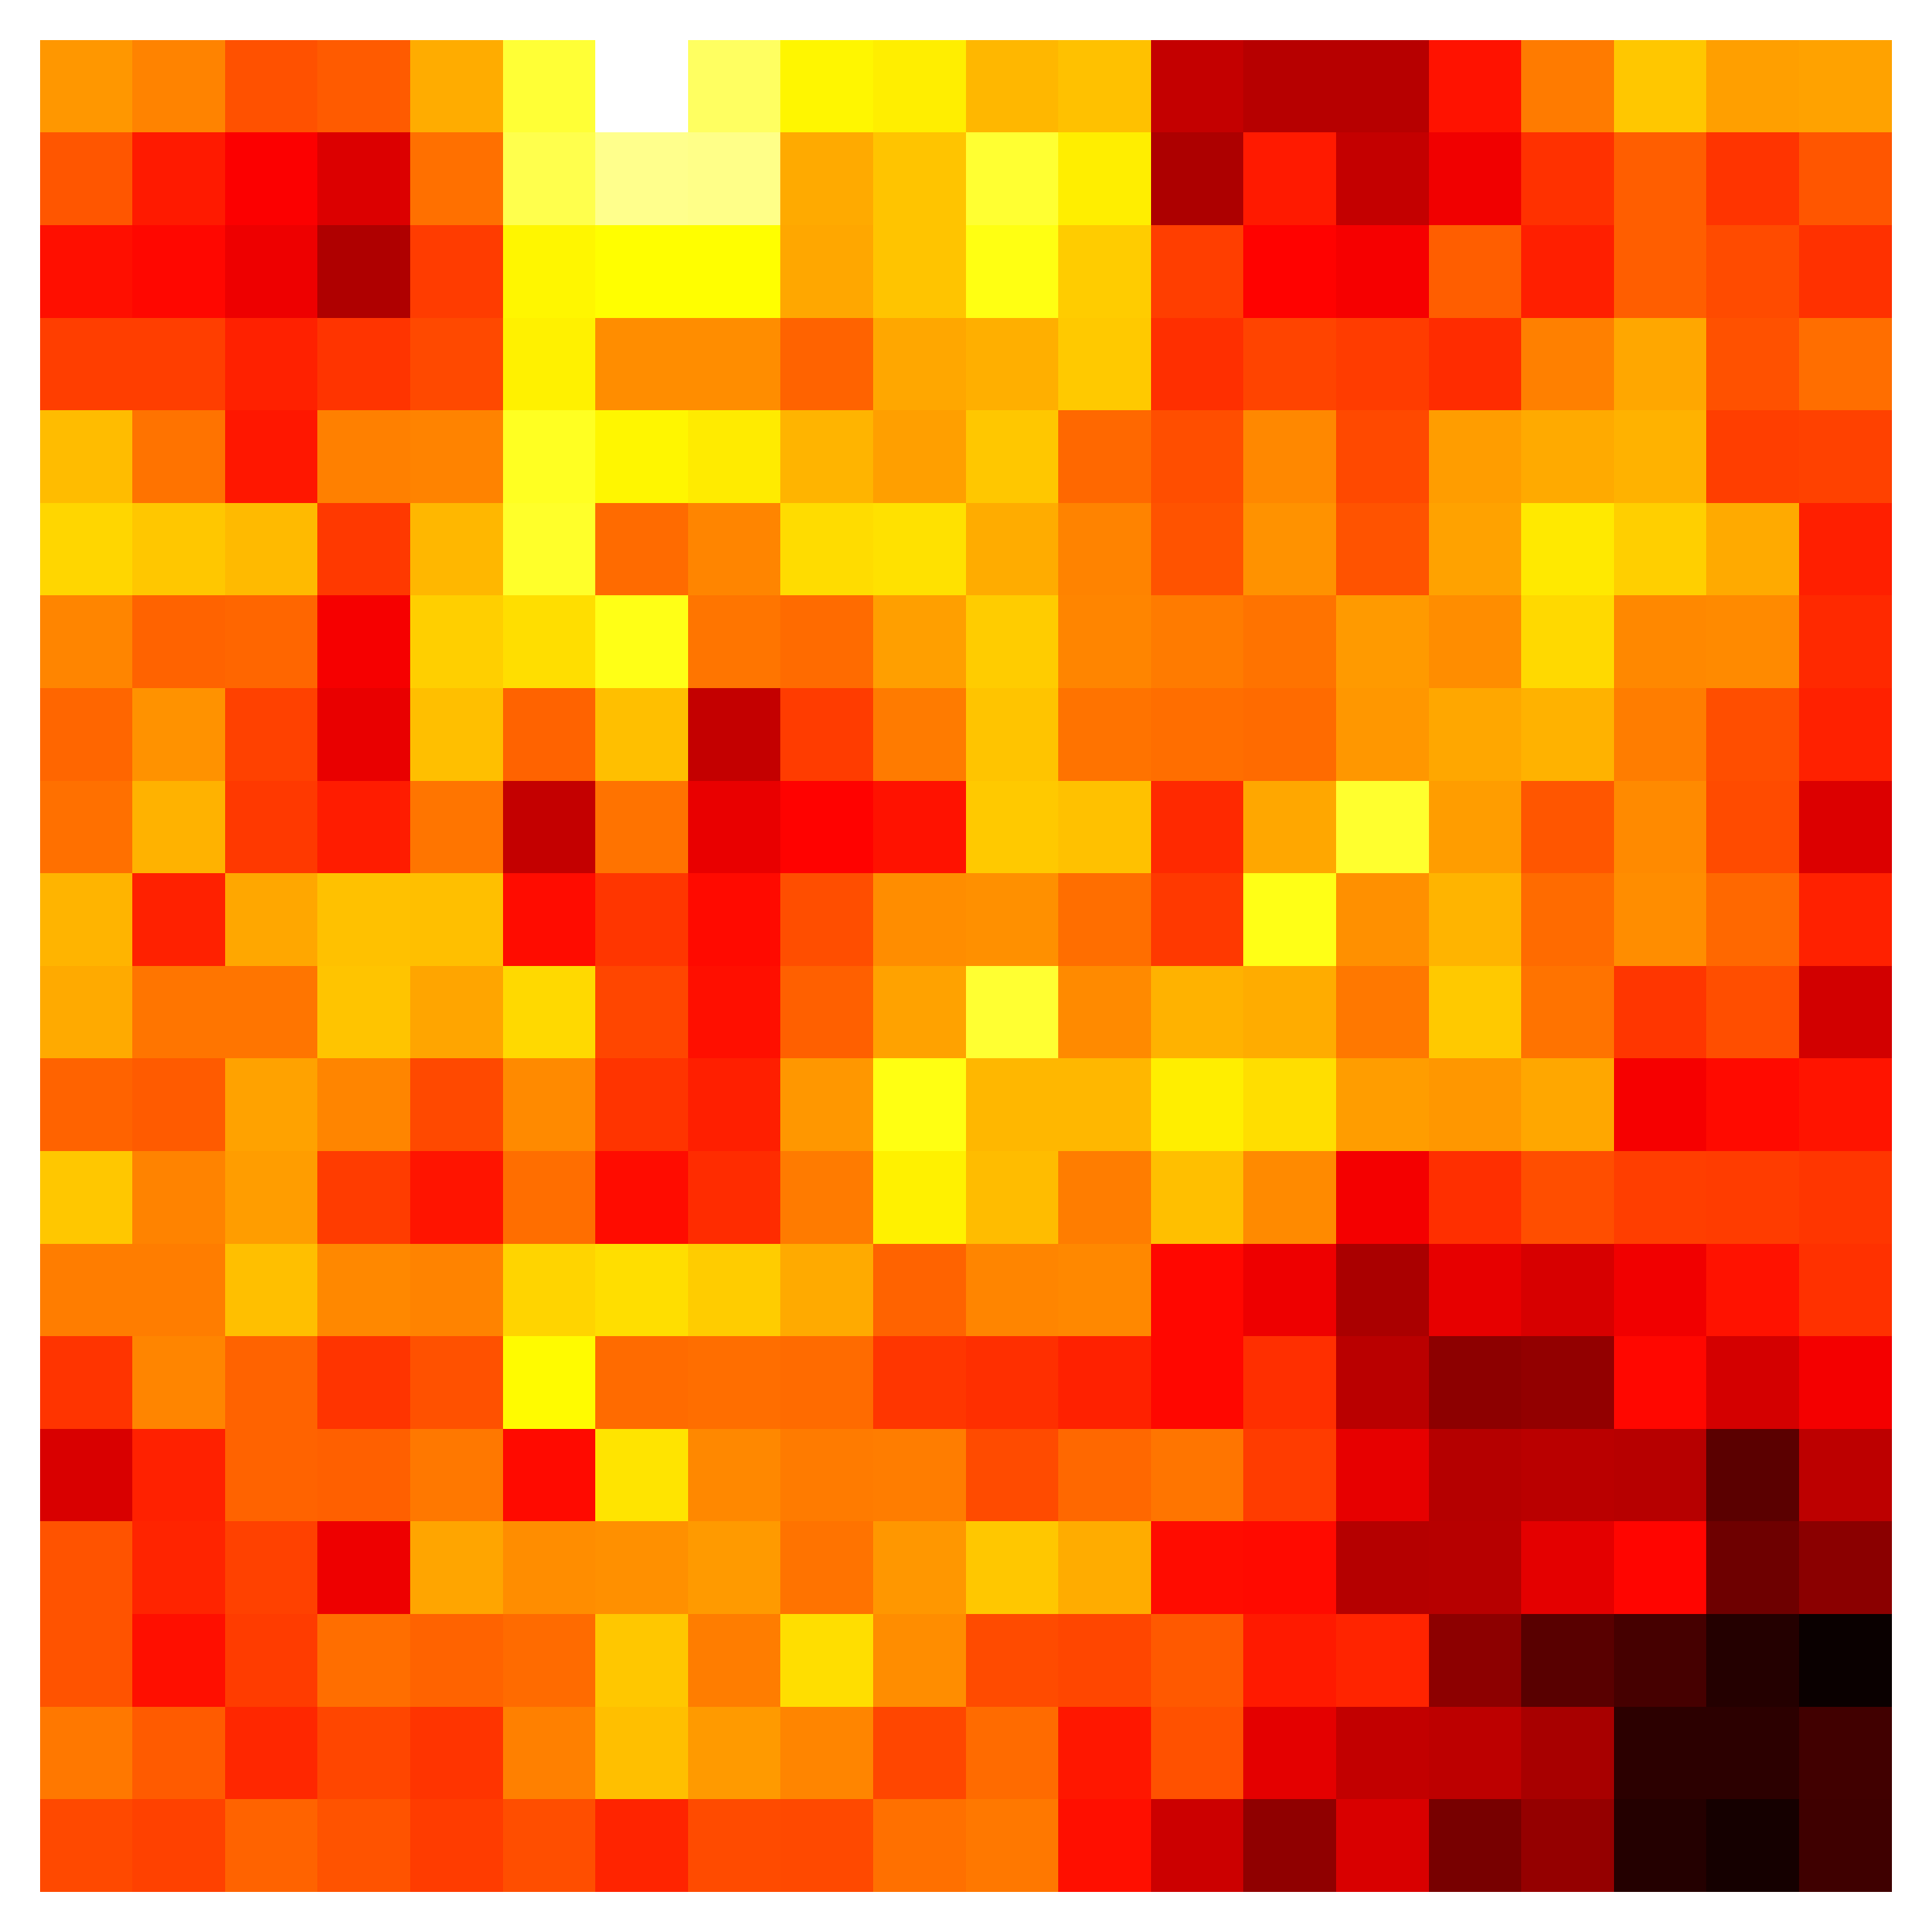

In [153]:
# Draw heat map
plt.figure(figsize=(10, 6), dpi=600)
plt.imshow(pv_array,cmap='hot')
plt.axis('off')
plt.savefig('pv_map.jpg', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()  

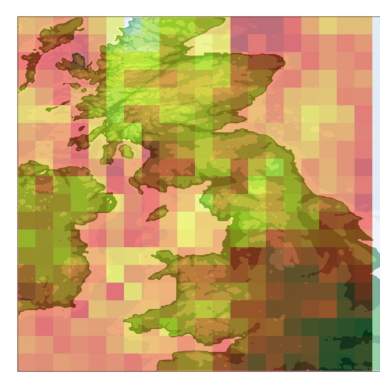

In [154]:
# Overlay geographic maps with heat maps
import matplotlib.image as mpimg
img1 = mpimg.imread('brit_elevation.jpg')
img2 = mpimg.imread('pv_map.jpg')
fig, ax = plt.subplots()
plt.axis('off')
ax.imshow(img1)
ax.imshow(img2, alpha=0.5)
plt.show()